In [1]:
import pysal as ps
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
ps.examples.available()

['baltim',
 'juvenile',
 'taz',
 'networks',
 'arcgis',
 'desmith',
 'virginia',
 'nat',
 'sacramento2',
 'Polygon',
 'south',
 'Point',
 'book',
 '10740',
 'chicago',
 'newHaven',
 'sids2',
 'mexico',
 'Line',
 'wmat',
 'street_net_pts',
 'us_income',
 'columbus',
 'burkitt',
 'geodanet',
 'stl',
 'snow_maps',
 'calemp']

In [3]:
ps.examples.explain('baltim')

{'description': 'Baltimore house sales prices and hedonics',
 'explanation': ['* baltim.dbf attribute data',
  '* baltim.shp shape file',
  '* baltim.shx spatial index file',
  '* baltim.tri.k12.kwt Kernel weights using a triangular kernel with 12 neares',
  '  neighbors',
  '* baltim_k4.gwt Nearest neighbor weights (4nn)',
  '* baltim_q.gal Queen contiguity file',
  '* baltimore.geojson',
  'Point data, n=211, k= 17.'],
 'name': 'baltim'}

In [4]:
data = ps.pdio.read_files(ps.examples.get_path('baltim'))

In [5]:
data.head()

,STATION,PRICE,NROOM,DWELL,NBATH,PATIO,FIREPL,AC,BMENT,NSTOR,GAR,AGE,CITCOU,LOTSZ,SQFT,X,Y,geometry
0,1,47.0,4.0,0.0,1.0,0.0,0.0,0.0,2.0,3.0,0.0,148.0,0.0,5.70,11.25,907.0,534.0,"(907.0, 534.0)"
1,2,113.0,7.0,1.0,2.5,1.0,1.0,1.0,2.0,2.0,2.0,9.0,1.0,279.51,28.92,922.0,574.0,"(922.0, 574.0)"
2,3,165.0,7.0,1.0,2.5,1.0,1.0,0.0,3.0,2.0,2.0,23.0,1.0,70.64,30.62,920.0,581.0,"(920.0, 581.0)"
3,4,104.3,7.0,1.0,2.5,1.0,1.0,1.0,2.0,2.0,2.0,5.0,1.0,174.63,26.12,923.0,578.0,"(923.0, 578.0)"
4,5,62.5,7.0,1.0,1.5,1.0,1.0,0.0,2.0,2.0,0.0,19.0,1.0,107.80,22.04,918.0,574.0,"(918.0, 574.0)"


In [6]:
mindist = ps.min_threshold_dist_from_shapefile(ps.examples.get_path('baltim.shp'))
mindist

21.319005605327842

In [7]:
W = ps.threshold_binaryW_from_array(np.array([data.X.values, data.Y.values]).T, 2*mindist)

In [8]:
W = ps.W(W.neighbors, W.weights)

In [9]:
ycols = ['PRICE']
xcols = ['NROOM', 'DWELL', 'LOTSZ', 'SQFT']#, 'AGE']#, 'NBATH', 'PATIO', 'FIREPL', 'AC', 'BMENT', 'NSTOR', 'GAR', ]
y = data[ycols].values
X = data[xcols].values

In [10]:
ols_reg = ps.spreg.OLS(y, X, w=W, spat_diag=True, moran=True, name_y=ycols, 
                       name_x = xcols)

In [11]:
print(ols_reg.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :   ['PRICE']                Number of Observations:         211
Mean dependent var  :     44.3072                Number of Variables   :           5
S.D. dependent var  :     23.6061                Degrees of Freedom    :         206
R-squared           :      0.5026
Adjusted R-squared  :      0.4929
Sum squared residual:   58207.850                F-statistic           :     52.0363
Sigma-square        :     282.562                Prob(F-statistic)     :   3.048e-30
S.E. of regression  :      16.810                Log likelihood        :    -892.297
Sigma-square ML     :     275.867                Akaike info criterion :    1794.595
S.E of regression ML:     16.6092                Schwarz criterion     :    1811.354

-----------------------------------------------------------------------------

In [12]:
effects, errs = ols_reg.betas, ols_reg.std_err

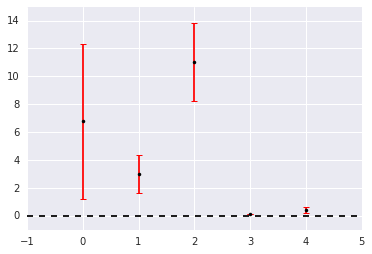

In [13]:
#plt.plot(range(0,len(effects.flatten())), effects.flatten(), '.k')
plt.axis([-1,5, -1,15])
plt.errorbar(range(0,len(effects.flatten())), effects, yerr=errs.flatten(), fmt='.k', ecolor='r', capthick=True)
plt.hlines(0, -1, 5, linestyle='--', color='k')

In [14]:
resids = y - ols_reg.predy

In [15]:
resids_alpha = resids / resids.max()

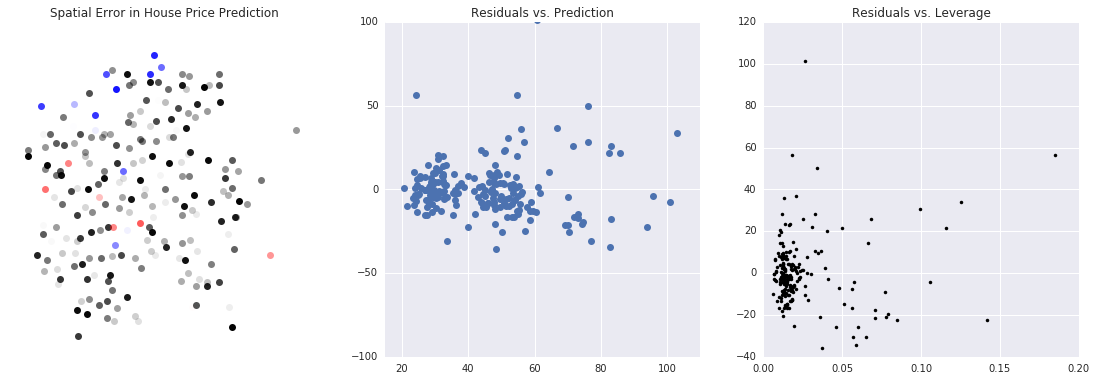

In [62]:
sns.set_context('notebook')
fig, ax = plt.subplots(1,3,figsize=(12*1.6,6))
for xi,yi,alpha in zip(data.X.values, data.Y.values, resids, ):
    if alpha+ ols_reg.std_y < 0:
        color='r'
    elif alpha - ols_reg.std_y > 0:
        color='b'
    else:
        color='k'
    ax[0].plot(xi,yi,color=color, marker='o', alpha = np.abs(alpha))#, alpha=alpha)
ax[0].axis([850, 1000, 500, 590])

ax[1].plot(ols_reg.predy, resids, 'o')
ax[1].axis([15,110,-100,100])

H = np.dot(X, np.linalg.inv(np.dot(X.T, X)))
H = np.dot(H, X.T)

lev = H.diagonal().reshape(-1,1)

ax[2].plot(lev, resids, '.k')
ax[0].set_axis_bgcolor('white')
ax[0].set_xticks([])
ax[0].set_yticks([])

ax[0].set_title('Spatial Error in House Price Prediction')
ax[1].set_title('Residuals vs. Prediction')
ax[2].set_title('Residuals vs. Leverage')

plt.show()

In [51]:
g = ax[0]

In [ ]:
g.set_axis_bgcolor

In [17]:
gmm_lag = ps.spreg.GM_Lag(y, X, w=W)#, name_y=ycols, name_x = xcols)

In [18]:
resids = y - gmm_lag.predy

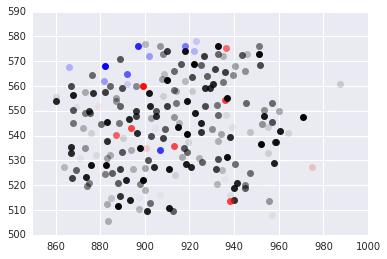

In [19]:
for xi,yi,alpha in zip(data.X.values, data.Y.values, resids):
    if alpha+ ols_reg.std_y < 0:
        color='r'
    elif alpha - ols_reg.std_y > 0:
        color='b'
    else:
        color='k'
    plt.plot(xi,yi,color=color, marker='o', alpha = np.abs(alpha))#, alpha=alpha)
plt.axis([850, 1000, 500, 590])
plt.show()

In [20]:
xcols.append('AGE')

In [21]:
X = data[xcols].values

In [24]:
reg_ommit = ps.spreg.OLS(y,X, name_y = ycols, name_x = xcols)

In [25]:
resids = y - reg_ommit.predy

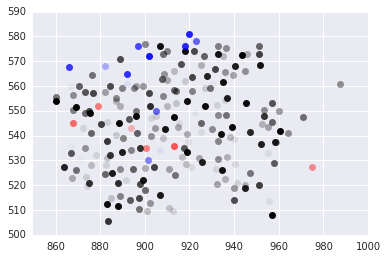

In [26]:
for xi,yi,alpha in zip(data.X.values, data.Y.values, resids):
    if alpha+ ols_reg.std_y < 0:
        color='r'
    elif alpha - ols_reg.std_y > 0:
        color='b'
    else:
        color='k'
    plt.plot(xi,yi,color=color, marker='o', alpha = np.abs(alpha))#, alpha=alpha)
plt.axis([850, 1000, 500, 590])
plt.show()